In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import timedelta
from timeit import default_timer as timer
from math import sqrt

## Images reading&resizing

In [2]:
img_l = np.asanyarray(Image.open("i1.jpg").resize((400,300), Image.BICUBIC).convert("RGB")).astype(np.int)
img_r = np.asanyarray(Image.open("i2.jpg").resize((400,300), Image.BICUBIC).convert("RGB")).astype(np.int)

## Params definition

In [3]:
kg_max=45
kv_max=14
kv_half = kv_max//2
height = img_r.shape[0]
length = img_r.shape[1]

In [4]:
#import shelve

In [5]:
#with shelve.open("lab2.db") as db:
    #db["img_shift2"] = img_shift2
    #img_shift2 = db["img_shift2"]

In [6]:
#np.save("img_shift.npy", img_shift2)

In [7]:
img_shift2 = np.load("img_shift.npy")

In [8]:
from scipy import ndimage

In [9]:
#k = np.ones((3,3))/9
#img_shift2[:,:,0] = ndimage.convolve(img_shift2[:,:,0], k, mode='reflect')
#img_shift2[:,:,1] = ndimage.convolve(img_shift2[:,:,1], k, mode='reflect')
#Image.fromarray((255.9*img_shift2/img_shift2.max()).astype(np.uint8))

# lab2 start

https://staff.fnwi.uva.nl/l.dorst/hz/chap11_13.pdf

In [10]:
from random import choices
from scipy.linalg import null_space

In [11]:
def is_smooth(img_shift, x, y, radius=2):
    for i in range(-radius,radius+1):
        for j in range(-radius,radius+1):
            if np.any(img_shift[y, x] != img_shift[y+i, x+j]):
                return False
    return True


map2draw = np.zeros((img_r.shape), dtype=np.uint8)

pairs = []
rejected_pairs = []
# (X, X')
for y_r in range(30, img_r.shape[0] - 30):
    for x_r in range(30, img_r.shape[1] - 30):
        x_r3d = [x_r, y_r, 1]
        
        dot_shift = img_shift2[y_r, x_r]
        
        x_l = int(x_r - dot_shift[0])
        y_l = int(y_r - (dot_shift[1] - kv_half))
        x_l3d = [x_l, y_l, 1]
        
        if is_smooth(img_shift2, x_r, y_r):
            pairs.append([x_l3d, x_r3d])
            map2draw[y_r, x_r] = 255
        else:
            rejected_pairs.append([x_l3d, x_r3d])

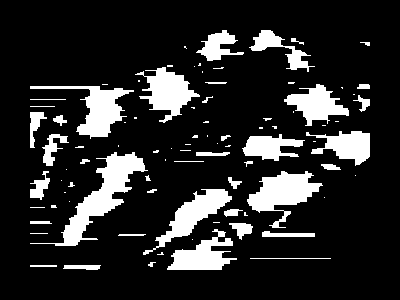

In [12]:
Image.fromarray(map2draw)

In [13]:
len(pairs)

19072

In [14]:
len(rejected_pairs)

62528

In [30]:
Boundary = 0.001
bestF = None
bestScore = 0

all_right = np.array([i[1] for i in pairs])
all_left = np.array([i[0] for i in pairs])

for iteration in range(20000):
    seven_pairs = choices(pairs, k=7)
    X_big = []
    for left, right in seven_pairs:
        x_l, y_l, z_l = left
        x_r, y_r, z_r = right
        X_big.append([x_r*x_l, x_r*y_l, x_r*z_l,
                      y_r*x_l, y_r*y_l, y_r*z_l,
                      z_r*x_l, z_r*y_l, z_r*z_l])
        # на попередній лінії була помилка,
        # через яку я декілька тижнів не міг зрозуміти чого не працює.
        # вічна пам'ять моїм загиблим нервовим клітинам.
        # F
    X_big = np.array(X_big)
    null_vectors = null_space(X_big)
    f1 = null_vectors[:,0].reshape((3,3))
    f2 = null_vectors[:,1].reshape((3,3))
    
    p = np.array([
     np.linalg.det(f2),
     np.linalg.det(f2)*np.trace(np.dot(np.linalg.inv(f2), f1)),
     np.linalg.det(f1)*np.trace(np.dot(np.linalg.inv(f1), f2)),
     np.linalg.det(f1),
    ])
    coefs = np.roots(p)
    for i in coefs[:1]:
        if np.iscomplex(i):
            continue
        F = f1+i*f2
        # both matrix have zero det
        score = np.sum(np.abs(np.einsum('ki,ij,kj->k', all_right, F, all_left)) < Boundary)
        if score > bestScore:
            bestScore = score
            bestF = F.copy()
            print("="*20)
            print("hit", bestScore/len(pairs))
            
            epipole = null_space(bestF, 1e-3)
            print(epipole)
            epipole = epipole/epipole[-1]
            epipole_strich = [epipole[0,0], epipole[1,0]]
            print("X:", epipole_strich[0])
            print("Y:", epipole_strich[1])

hit 0.0003670302013422819
[[-0.74421321-0.j]
 [-0.66793561-0.j]
 [-0.00295148-0.j]]
X: (252.14958121379058-0j)
Y: (226.30568990142817-0j)
hit 0.000576761744966443
[[0.3138456 ]
 [0.9494733 ]
 [0.00117762]]
X: 266.5073965493603
Y: 806.2615973496731
hit 0.012688758389261746
[[-0.61228806]
 [-0.79062739]
 [-0.00341565]]
X: 179.25985033570387
Y: 231.4723366833177
hit 0.03193162751677853
[[0.55681681]
 [0.83062777]
 [0.0035425 ]]
X: 157.18206554349686
Y: 234.47530267329896
hit 0.04860528523489933
[[-0.73168949]
 [-0.68163151]
 [-0.00299533]]
X: 244.27673443507345
Y: 227.5647293087481
hit 0.07052223154362416
[[-0.59014147]
 [-0.80729158]
 [-0.0036548 ]]
X: 161.4704156101099
Y: 220.88552369293703
hit 0.10334521812080537
[[0.63680536]
 [0.77102322]
 [0.00145889]]
X: 436.5000000122986
Y: 528.500000013918
hit 0.16401006711409397
[[-3.16227766e-01-0.j]
 [-9.48683298e-01-0.j]
 [-1.03139719e-13-0.j]]
X: (3066013453763.2183-0j)
Y: (9198040360748.72-0j)
hit 0.2648909395973154
[[-4.47213595e-01]
 [-8.

## Фундаментальна матриця

In [16]:
np.round(bestF, 2)

array([[  -0.  ,   -0.  ,   33.76],
       [   0.  ,    0.  ,   -0.  ],
       [ -33.76,    0.  , -270.12]])

In [17]:
bestF

array([[-2.40556246e-13, -1.37909701e-11,  3.37649795e+01],
       [ 1.38704152e-11,  4.06575815e-20, -8.82756535e-10],
       [-3.37649795e+01,  9.96214999e-10, -2.70119836e+02]])

In [18]:
np.save("bestF.npy", bestF)
np.save("bestScore.npy", bestScore)

In [19]:
#bestF = np.load("bestF.npy")
#bestScore = np.load("bestScore.npy")

In [20]:
#with shelve.open("lab2.db") as db:
#    #db["bestF"] = bestF
#    #db["bestScore"] = bestScore
#    bestF = db["bestF"]
#    bestScore = db["bestScore"]
#    #img_shift2 = db["img_shift2"]

## Відсоток точок, які задовольняють умову до фундаментальної матриці

In [21]:
print(round(100*bestScore/len(pairs), 2),"%")

31.06 %


## Епіполярна точка у 3-х координатах

In [22]:
epipole = null_space(bestF, 1e-3)
epipole = epipole/epipole[-1]
epipole

array([[6.42362958e+01],
       [2.44827378e+12],
       [1.00000000e+00]])

In [23]:
np.linalg.det(bestF)

4.6356479230574774e-17

In [24]:
epipole_strich = [epipole[0,0], epipole[1,0]]

## Епіполярна точка

In [25]:
print("X:", epipole_strich[0])
print("Y:", epipole_strich[1])

X: 64.23629581312264
Y: 2448273784925.521


## Ліве зображення

In [26]:
from PIL import ImageDraw

In [27]:
image2show = Image.open("i1.jpg").resize((400,300), Image.BICUBIC).convert("RGB")
draw = ImageDraw.Draw(image2show)
for i in range(11):
    draw.line((0, i*30, epipole_strich[0], epipole_strich[1]), fill=128)
image2show

KeyboardInterrupt: 

## Праве зображення

In [ ]:
Image.open("i2.jpg").resize((400,300), Image.BICUBIC).convert("RGB")